<a href="https://colab.research.google.com/github/kavithachitriki/OCRProject/blob/main/KerasRetinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
!git clone https://github.com/fizyr/keras-retinanet

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 26.78 MiB/s, done.
Resolving deltas: 100% (4201/4201), done.


In [2]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168023 sha256=0c6dcbdecf5b8050aa14d48a34f1aea1244d391ee86f6102e7e3c1014a5f9a7c
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=50ea63338e6ee05323186f3ce827fff9160c87c242e571492654568f3d472bb5
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -

In [4]:
!pip install gdown
!pip install tensorflow.gpu

     |████████████████████████████████| 394.3MB 40kB/s 


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr,preprocess_image,resize_image
from keras_retinanet.utils.visualization import draw_box,draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)

rcParams['figure.figsize'] = 22,10

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
os.makedirs("snapshots",exist_ok=True)

In [9]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:02, 123MB/s]


In [66]:
dataset=dict()
dataset["image_name"]=list()
dataset["x_min"]=list()
dataset["y_min"]=list()
dataset["x_max"]=list()
dataset["y_max"]=list()
dataset["class_name"]=list()

counter=0
#creating dataset
#dataset["image_name"].append("")
img1="https://drive.google.com/file/d/1YtDG1FdLienKm5I-n5vwF2Frslsk6-Rj/view?usp=sharing"
img2="https://drive.google.com/file/d/1hYujwJlDNHsrtDjTSllDFfiqwQx15pdK/view?usp=sharing"
img3="https://drive.google.com/file/d/1fRKNgE0eYCJvjw1XWTJzn8K071f4HQuG/view?usp=sharing"
img4="https://drive.google.com/file/d/1nXYCND08BXrcW5ieZsX4NJQQN3UwBagm/view?usp=sharing"

counter=0
img=Image.open('../pan1.jpeg').convert('RGB')
img.save(f'pantest{counter}.jpeg','JPEG')
dataset["image_name"].append(f'pantest{counter}.jpeg')
dataset["class_name"].append("check_mark")

counter=1
img=Image.open('../pan2.jpeg').convert('RGB')
img.save(f'pantest{counter}.jpeg','JPEG')
dataset["image_name"].append(f'pantest{counter}.jpeg')
dataset["class_name"].append("check_mark")

counter=2
img=Image.open('../pan3.jpeg').convert('RGB')
img.save(f'pantest{counter}.jpeg','JPEG')
dataset["image_name"].append(f'pantest{counter}.jpeg')
dataset["class_name"].append("check_mark")

counter=3
img=Image.open('../pan4.jpeg').convert('RGB')
img.save(f'pantest{counter}.jpeg','JPEG')
dataset["image_name"].append(f'pantest{counter}.jpeg')
dataset["class_name"].append("check_mark")


width=1
height=1
#First Image
x_min=140
y_min=248
x_max=156
y_max=264
dataset["x_min"].append( x_min* width)
dataset["y_min"].append( y_min* height)
dataset["x_max"].append( x_max * width)
dataset["y_max"].append( y_max * height)

#second image
x_min=146
y_min=245
x_max=162
y_max=263
dataset["x_min"].append( x_min* width)
dataset["y_min"].append( y_min* height)
dataset["x_max"].append( x_max * width)
dataset["y_max"].append( y_max * height)

#third image
x_min=127
y_min=343
x_max=148
y_max=361
dataset["x_min"].append( x_min* width)
dataset["y_min"].append( y_min* height)
dataset["x_max"].append( x_max * width)
dataset["y_max"].append( y_max * height)

#fourth image
x_min=172
y_min=244
x_max=191
y_max=261
dataset["x_min"].append( x_min* width)
dataset["y_min"].append( y_min* height)
dataset["x_max"].append( x_max * width)
dataset["y_max"].append( y_max * height)


In [67]:
print(dataset["image_name"])
  

['pantest0.jpeg', 'pantest1.jpeg', 'pantest2.jpeg', 'pantest3.jpeg']


In [68]:
df=pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,pantest0.jpeg,140,248,156,264,check_mark
1,pantest1.jpeg,146,245,162,263,check_mark
2,pantest2.jpeg,127,343,148,361,check_mark
3,pantest3.jpeg,172,244,191,261,check_mark


In [69]:
def show_image_objects(image_row):
  img_path = image_row.image_name
  print(image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max)
  box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr('../'+img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  draw_box(draw, box, color=(255, 255, 0))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

140 248 156 264


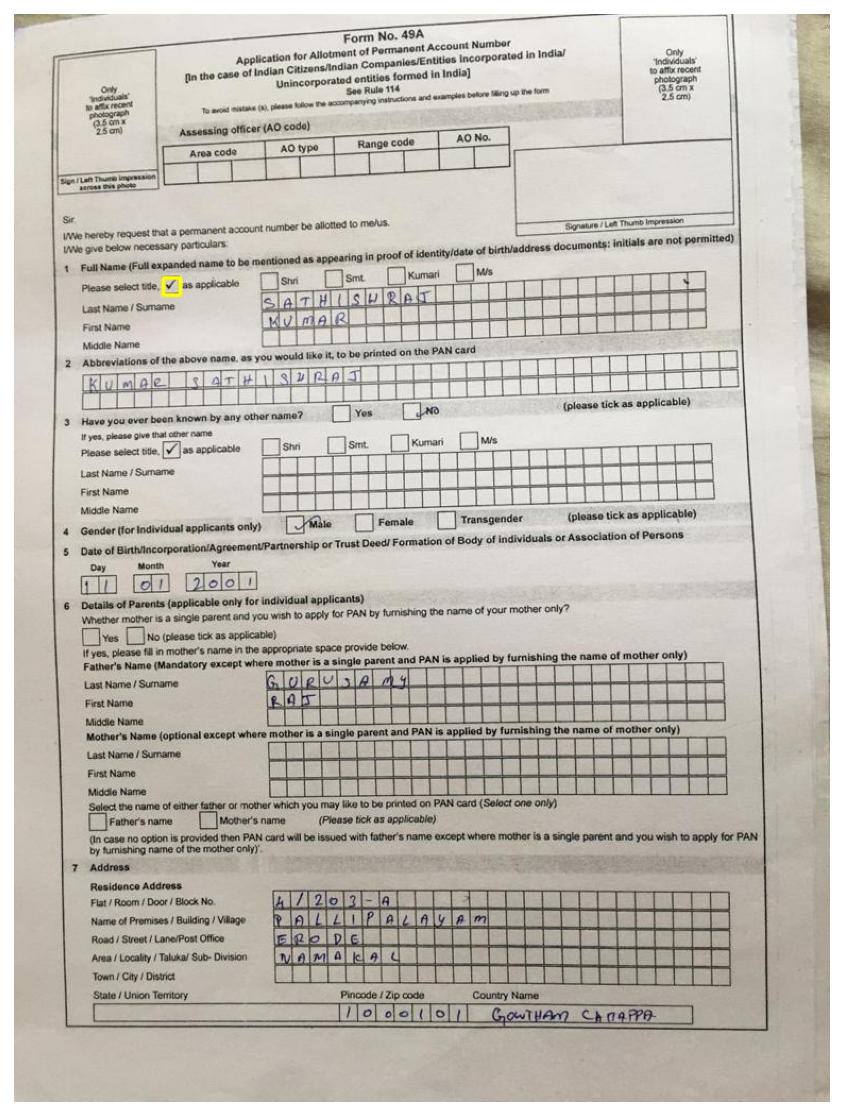

In [70]:

show_image_objects(df.iloc[0])



In [71]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)

In [72]:
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
1,pantest1.jpeg,146,245,162,263,check_mark


In [73]:
ANNOTATIONS_FILE="annotations.csv"
CLASSES_FILE="classes.csv"

In [74]:
train_df.to_csv(ANNOTATIONS_FILE,index=False,header=None)

In [75]:
classes=set(['check_mark'])

with open(CLASSES_FILE,'w') as f:
  for i,line in enumerate(sorted(classes)):
    f.write('{}, {}\n'.format(line,i))

In [76]:
!head annotations.csv

pantest3.jpeg,172,244,191,261,check_mark
pantest0.jpeg,140,248,156,264,check_mark
pantest2.jpeg,127,343,148,361,check_mark


In [77]:
!head classes.csv

check_mark, 0


In [81]:
#Training
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [86]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 1 --steps 1 --epochs 2 csv annotations.csv classes.csv

2021-03-08 11:21:52.759025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-03-08 11:21:54.922193: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-08 11:21:54.923456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-08 11:21:54.934524: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-08 11:21:54.934573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (374ba9597923): /proc/driver/nvidia/version does not exist
2021-03-08 11:21:54.934891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

In [87]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_02.h5
resnet50_csv_01.h5    resnet50_csv_10.h5


In [88]:
model_path=os.path.join('snapshots',sorted(os.listdir('snapshots'),reverse=True)[0])

In [89]:
model_path

'snapshots/resnet50_csv_10.h5'

In [90]:
model=models.load_model(model_path,backbone_name='resnet50')

In [91]:
model=models.convert_model(model)

In [92]:
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

In [93]:
labels_to_names

{0: 'check_mark'}

In [95]:
THRES_SCORE = 0.6
def show_detected_objects(image_row):
  img_path = image_row.image_name
  true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  image=preprocess_image(image)
  image,scale=resize_image(image)
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image,axis=0))
  boxes=boxes/scale
  draw_box(draw, true_box, color=(255, 255, 0))
  #draw detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
      break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    caption = "{:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [96]:
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
1,pantest1.jpeg,146,245,162,263,check_mark


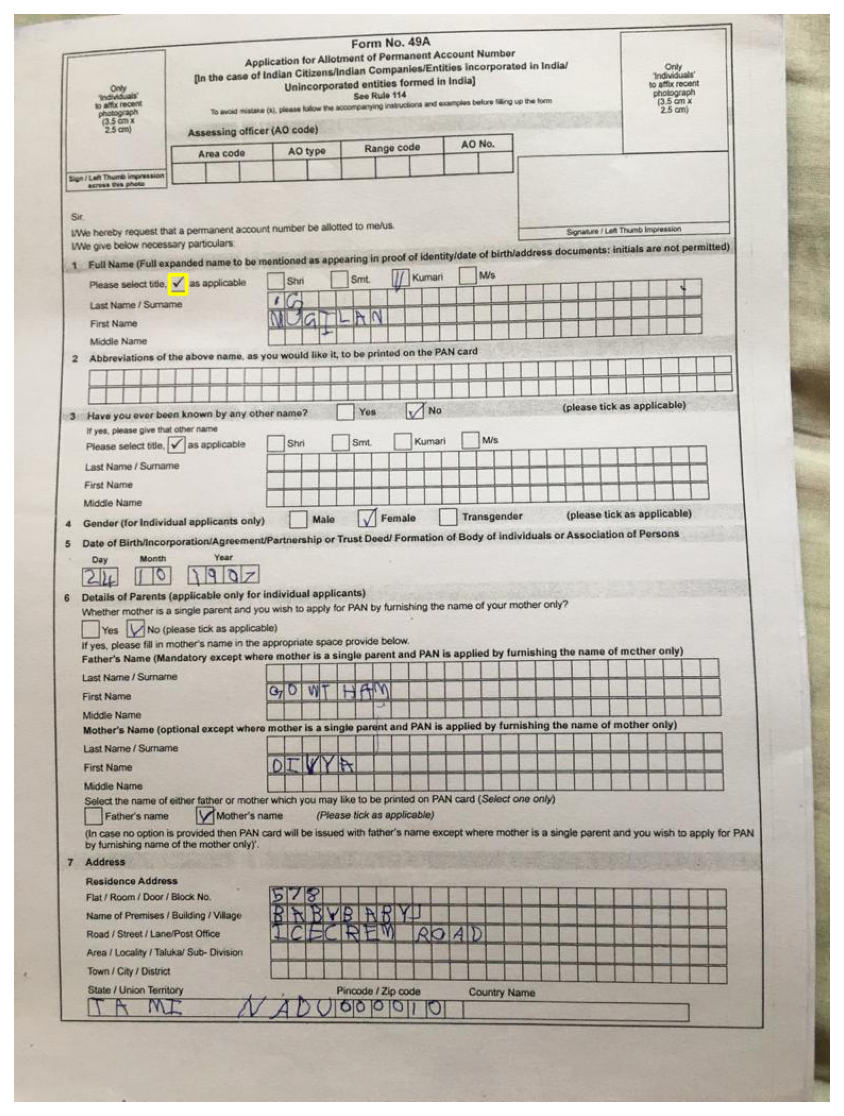

In [97]:
show_detected_objects(test_df.iloc[0])
  

# New Section